In [1]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("Oranges")

# Modeling Imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Unpickling cleaned dataframe from 1_Data_Cleaning.ipynb

redo_pickle = False

if redo_pickle == True:
    with open('clean_df.pickle','rb') as f:
        clean_df = pickle.load(f)

## Visualizations Before Modeling

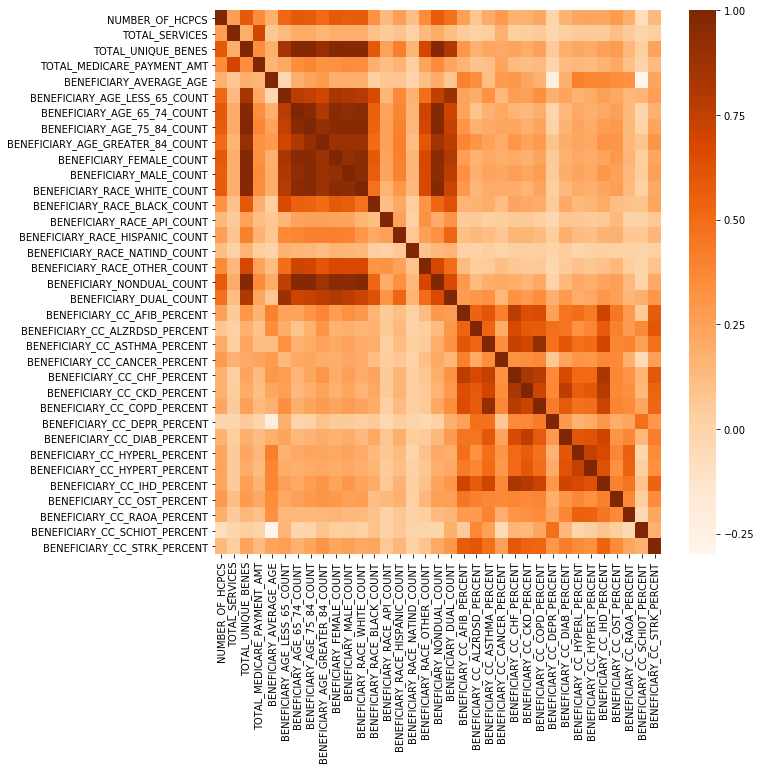

In [3]:
# Creating heatmap to look for multicolinearity and correlations 
# between target(TOTAL_MEDICARE_PAYMENT_AMT) and all predictor variables

plt.figure(figsize=(10,10))
sns.heatmap(clean_df.corr(), cmap='Oranges');

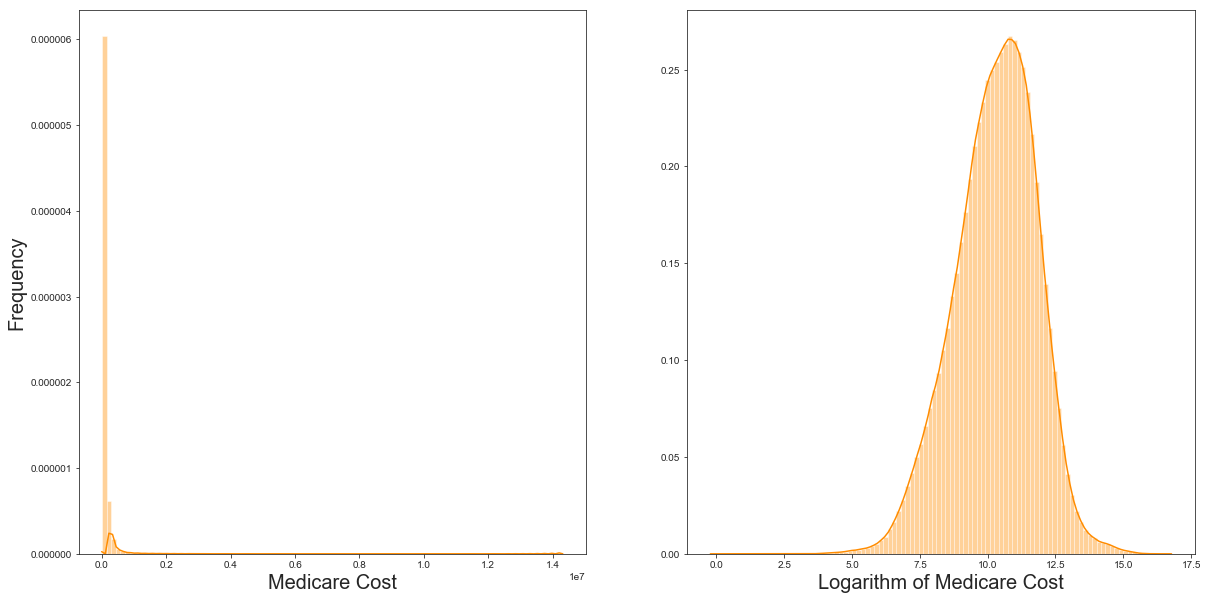

In [6]:
# Before and After Logarithmic transformation of target variable(Medicare Cost per Provider)
sns.set_style("ticks")

plt.figure(figsize=(20,10))
plt.subplot(121)
sns.distplot(clean_df.TOTAL_MEDICARE_PAYMENT_AMT, bins=100, color='darkorange')

plt.xlabel('Medicare Cost', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.subplot(122)
sns.distplot(np.log(clean_df.TOTAL_MEDICARE_PAYMENT_AMT), bins=100, color='darkorange')
plt.xlabel('Logarithm of Medicare Cost', fontsize=20);

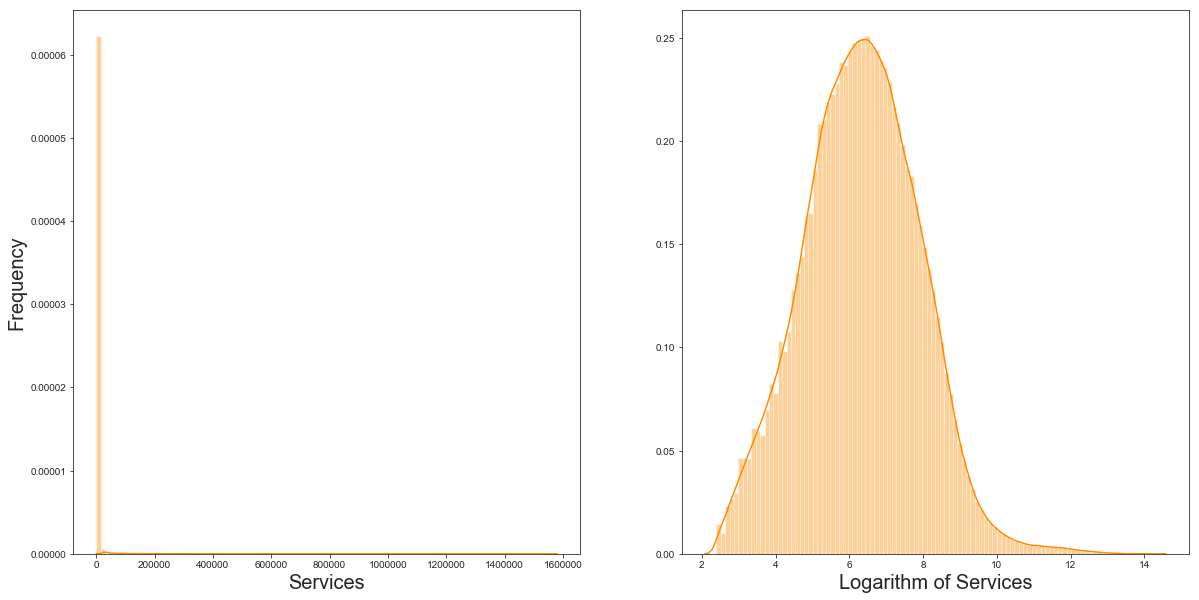

In [7]:
# Before and After Logarithmic transformation of predictor variable (Total Services)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.distplot(clean_df.TOTAL_SERVICES, bins=100, color='darkorange')

plt.xlabel('Services', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.subplot(122)
sns.distplot(np.log(clean_df.TOTAL_SERVICES), bins=100, color='darkorange')
plt.xlabel('Logarithm of Services', fontsize=20);

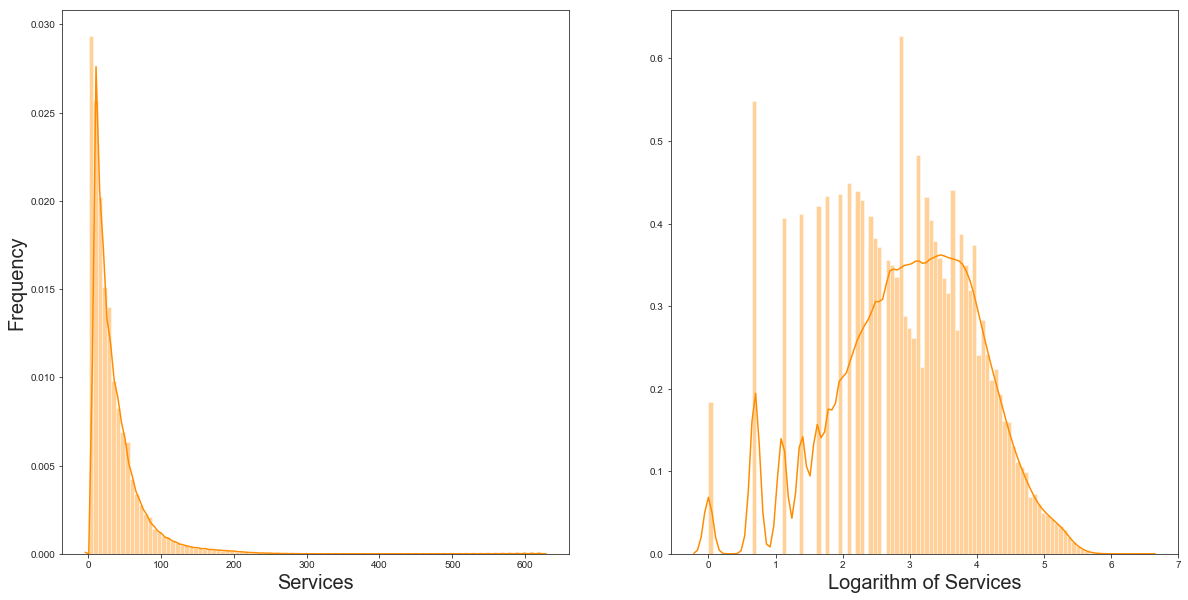

In [8]:
# Before and After Logarithmic transformation of predictor variable (Number of Unique Medical Services)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.distplot(clean_df.NUMBER_OF_HCPCS, bins=100, color='darkorange')

plt.xlabel('Services', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.subplot(122)
sns.distplot(np.log(clean_df.NUMBER_OF_HCPCS), bins=100, color='darkorange')
plt.xlabel('Logarithm of Services', fontsize=20);

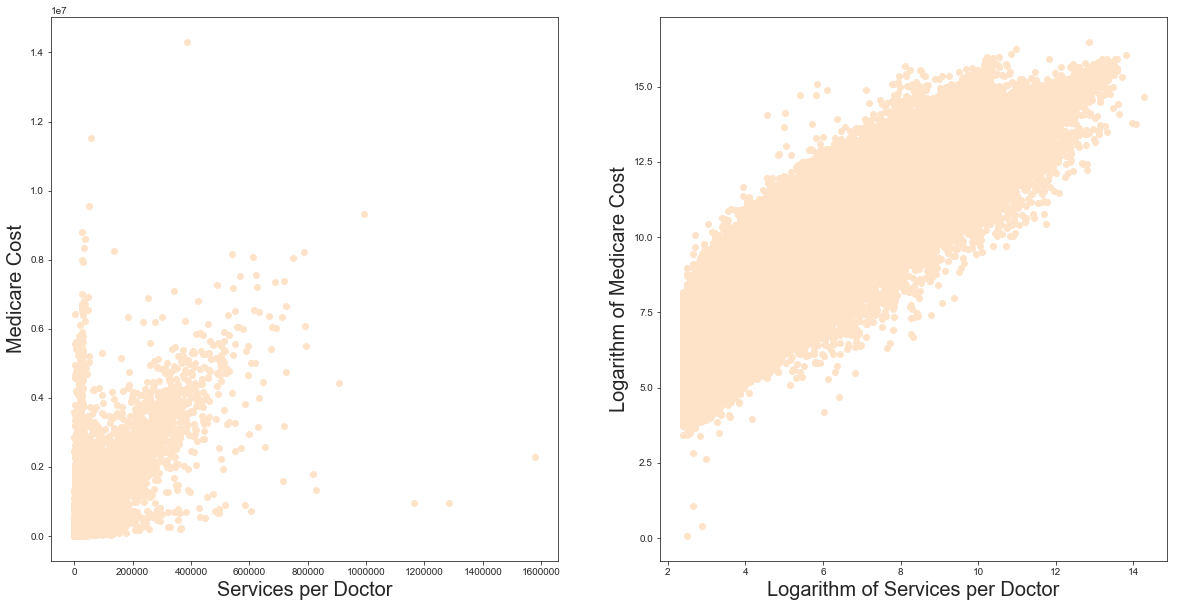

In [9]:
# Before and after log transformation of the above target and predictor variable

# This demonstrates that the log-log transformation leads to a greater linearity
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(x=clean_df.TOTAL_SERVICES, y=clean_df.TOTAL_MEDICARE_PAYMENT_AMT, alpha=1)
plt.xlabel('Services per Doctor', fontsize=20)
plt.ylabel('Medicare Cost', fontsize=20)

plt.subplot(122)
plt.scatter(np.log(clean_df.TOTAL_SERVICES),np.log(clean_df.TOTAL_MEDICARE_PAYMENT_AMT), alpha=1)
plt.xlabel('Logarithm of Services per Doctor', fontsize=20)
plt.ylabel('Logarithm of Medicare Cost', fontsize=20);

## Initial Model Testing without Feature Engineering

In [11]:
def ols_formula(df, dependent_var, *excluded_cols):
    '''
    Returns the "R style" formula for the patsy function given
    the dataframe, target variable and optional excluded columns
    as strings
    '''
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [12]:
## Initial Statsmodel OLS 
# (Variable naming clarification: no_fe means no feature engineering)

formula = ols_formula(clean_df, 'TOTAL_MEDICARE_PAYMENT_AMT')
y, X = patsy.dmatrices(formula, data=clean_df, return_type="dataframe")
model_no_fe = sm.OLS(y, X)
fit_no_fe = model_no_fe.fit()
fit_no_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     TOTAL_MEDICARE_PAYMENT_AMT   R-squared:                       0.619
Model:                                    OLS   Adj. R-squared:                  0.619
Method:                         Least Squares   F-statistic:                     9398.
Date:                        Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                                17:51:15   Log-Likelihood:            -1.2963e+07
No. Observations:                      984927   AIC:                         2.593e+07
Df Residuals:                          984756   BIC:                         2.593e+07
Df Model:                                 170                                         
Covariance Type:                    nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        4.078e+04   1.03e+04      3.958      0.000    2.06e+04     6.1e+04
NPPES_PROVIDER_GENDER[T.M]                                       1.058e+04    296.905     35.644      0.000       1e+04    1.12e+04
NPPES_PROVIDER_STATE[T.AL]                                      -4870.7260   2785.968     -1.748      0.080   -1.03e+04     589.677
NPPES_PROVIDER_STATE[T.AR]                                      -7227.0066   2923.865     -2.472      0.013    -1.3e+04   -1496.330
NPPES_PROVIDER_STATE[T.AZ]                                       3095.6087   2714.038      1.141      0.254   -2223.814    8415.031
NPPES_PROVIDER_STATE[T.CA]                                      -1085.5877   2597.608     -0.418      0.676   -6176.811    4005.636
NPPES_PROVIDER_STATE[T.CO]                                      -9367.1961   2736.862     -3.423      0.001   -1.47e+04   -4003.039
NPPES_PROVIDER_STATE[T.CT]                                      -1.121e+04   2763.190     -4.057      0.000   -1.66e+04   -5794.032
NPPES_PROVIDER_STATE[T.DC]                                      -1.353e+04   3367.363     -4.018      0.000   -2.01e+04   -6929.514
NPPES_PROVIDER_STATE[T.DE]                                       7729.8874   3315.321      2.332      0.020    1231.970    1.42e+04
NPPES_PROVIDER_STATE[T.FL]                                       3917.3110   2620.026      1.495      0.135   -1217.852    9052.474
NPPES_PROVIDER_STATE[T.GA]                                      -7176.9215   2678.571     -2.679      0.007   -1.24e+04   -1927.013
NPPES_PROVIDER_STATE[T.HI]                                      -2.319e+04   3389.511     -6.842      0.000   -2.98e+04   -1.65e+04
NPPES_PROVIDER_STATE[T.IA]                                      -1.185e+04   2839.747     -4.175      0.000   -1.74e+04   -6288.784
NPPES_PROVIDER_STATE[T.ID]                                      -1.776e+04   3119.225     -5.692      0.000   -2.39e+04   -1.16e+04
NPPES_PROVIDER_STATE[T.IL]                                      -8318.0051   2633.468     -3.159      0.002   -1.35e+04   -3156.497
NPPES_PROVIDER_STATE[T.IN]                                      -9421.2557   2710.940     -3.475      0.001   -1.47e+04   -4107.905
NPPES_PROVIDER_STATE[T.KS]                                      -9843.1372   2850.945     -3.453      0.001   -1.54e+04   -4255.382
NPPES_PROVIDER_STATE[T.KY]                                      -7584.0741   2767.559     -2.740      0.006    -1.3e+04   -2159.751
NPPES_PROVIDER_STATE[T.LA]                                      -9980.4309   2779.283     -

In [29]:
def residual_normality_visualizations(model):
    '''Returns visualizations(Q-Q Plot and scatter plot of predictions vs. residuals) 
    checking residuals for normality, using a linear regression model as input.
    '''
    plt.figure(figsize=(8,15))
    
    # Finding residuals of model 
    res = model.resid
    
    # Q-Q Plot
    plt.subplot(211)
    stats.probplot(res,dist='norm',plot=plt)
    plt.title('Normal Q-Q plot')
    
    # Predictions vs Residuals Scatter plot
    plt.subplot(212)
    plt.scatter(model.predict(),res)
    plt.title('Predicited vs Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual(Model Errors)')
    
    plt.show();

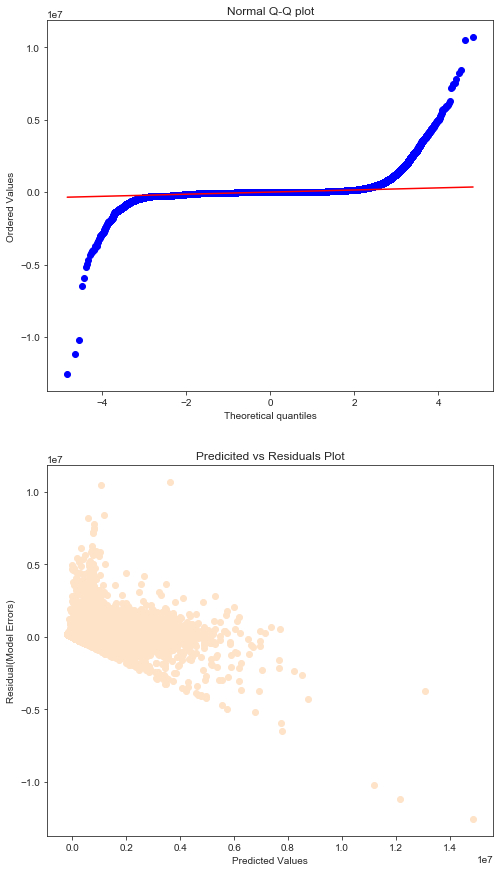

In [30]:
residual_normality_visualizations(fit_no_fe)

# Q-Q Plot: Residuals do not fit a normal distribution on the tails
# Predicted vs Residuals: Residuals have a clear boundary and do not follow a normal distribution

In [31]:
### Running OLS and Ridge Regression in sklearn

# Removing 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.4, random_state=10)

# Splitting into val and train sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=11)

# Scaling features for Ridge Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

#Setting up OLS and Ridge Regression
lm = LinearRegression()
lm_reg = Ridge(alpha=1)

# Training and testing
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

Linear Regression val R^2: 0.581
Ridge Regression val R^2: 0.581


## Model Testing after Feature Engineering

In [32]:
clean_df['TOTAL_MEDICARE_PAYMENT_AMT'] = np.log(clean_df.TOTAL_MEDICARE_PAYMENT_AMT)
clean_df['TOTAL_UNIQUE_BENES'] = np.log(clean_df.TOTAL_UNIQUE_BENES)
clean_df['TOTAL_SERVICES'] = np.log(clean_df.TOTAL_SERVICES)
clean_df['NUMBER_OF_HCPCS'] = np.log(clean_df.NUMBER_OF_HCPCS)

In [34]:
## Statsmodel OLS with feature engineering
# (Variable naming clarification: with_fe means with feature engineering)

formula = ols_formula(clean_df, 'TOTAL_MEDICARE_PAYMENT_AMT')
y, X = patsy.dmatrices(formula, data=clean_df, return_type="dataframe",)
model_with_fe = sm.OLS(y, X)
fit_with_fe = model_with_fe.fit()
fit_with_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     TOTAL_MEDICARE_PAYMENT_AMT   R-squared:                       0.920
Model:                                    OLS   Adj. R-squared:                  0.920
Method:                         Least Squares   F-statistic:                 6.651e+04
Date:                        Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                                18:34:26   Log-Likelihood:            -5.5757e+05
No. Observations:                      984927   AIC:                         1.115e+06
Df Residuals:                          984756   BIC:                         1.117e+06
Df Model:                                 170                                         
Covariance Type:                    nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           4.7948      0.035    137.108      0.000       4.726       4.863
NPPES_PROVIDER_GENDER[T.M]                                          0.0351      0.001     34.806      0.000       0.033       0.037
NPPES_PROVIDER_STATE[T.AL]                                         -0.4031      0.009    -42.711      0.000      -0.422      -0.385
NPPES_PROVIDER_STATE[T.AR]                                         -0.3961      0.010    -39.987      0.000      -0.415      -0.377
NPPES_PROVIDER_STATE[T.AZ]                                         -0.2104      0.009    -22.886      0.000      -0.228      -0.192
NPPES_PROVIDER_STATE[T.CA]                                         -0.1583      0.009    -17.985      0.000      -0.176      -0.141
NPPES_PROVIDER_STATE[T.CO]                                         -0.2227      0.009    -24.019      0.000      -0.241      -0.205
NPPES_PROVIDER_STATE[T.CT]                                         -0.2233      0.009    -23.850      0.000      -0.242      -0.205
NPPES_PROVIDER_STATE[T.DC]                                         -0.2117      0.011    -18.560      0.000      -0.234      -0.189
NPPES_PROVIDER_STATE[T.DE]                                         -0.2153      0.011    -19.174      0.000      -0.237      -0.193
NPPES_PROVIDER_STATE[T.FL]                                         -0.2145      0.009    -24.162      0.000      -0.232      -0.197
NPPES_PROVIDER_STATE[T.GA]                                         -0.2887      0.009    -31.822      0.000      -0.307      -0.271
NPPES_PROVIDER_STATE[T.HI]                                         -0.2149      0.011    -18.710      0.000      -0.237      -0.192
NPPES_PROVIDER_STATE[T.IA]                                         -0.3360      0.010    -34.935      0.000      -0.355      -0.317
NPPES_PROVIDER_STATE[T.ID]                                         -0.3259      0.011    -30.843      0.000      -0.347      -0.305
NPPES_PROVIDER_STATE[T.IL]                                         -0.2374      0.009    -26.606      0.000      -0.255      -0.220
NPPES_PROVIDER_STATE[T.IN]                                         -0.3304      0.009    -35.974      0.000      -0.348      -0.312
NPPES_PROVIDER_STATE[T.KS]                                         -0.3145      0.010    -32.566      0.000      -0.333      -0.296
NPPES_PROVIDER_STATE[T.KY]                                         -0.4117      0.009    -43.914      0.000      -0.430      -0.393
NPPES_PROVIDER_STATE[T.LA]                                         -0.3194      0.009    -3

In [35]:
### Running OLS and Ridge Regression

# Removing 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.4, random_state=10)

# Splitting into val and train sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=11)

# Scaling features for Ridge Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

#Setting up OLS and Ridge Regression
lm = LinearRegression()
lm_reg = Ridge(alpha=1)

# Training and testing
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

Linear Regression val R^2: 0.920
Ridge Regression val R^2: 0.920


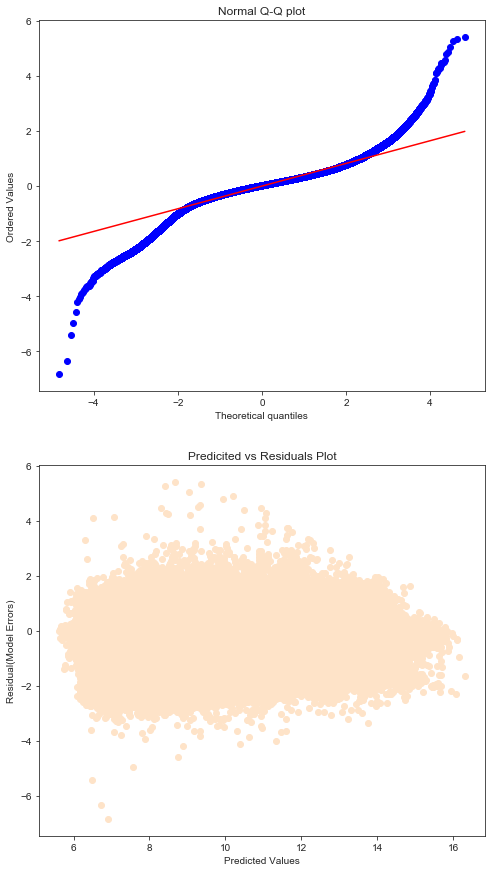

In [37]:
residual_normality_visualizations(fit_with_fe)

# Q-Q Plot:Tails still not fitting a normal distribution
# Predicted vs Residuals: Residuals looking more normally distributed now

In [36]:
# R Squared of Ridge Model on out of sample test data
lm_reg.score(X_test_scaled, y_test)

0.9199198080946224

## Cross Validation for Final Model (choosing between LASSO and RIDGE)

In [283]:
#### Lasso Cross Validation for best alpha

# Creating X and y
formula = ols_formula(clean_df, 'TOTAL_MEDICARE_PAYMENT_AMT')
y, X = patsy.dmatrices(formula, data=clean_df, return_type="dataframe")
# Setting up test and train split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# Scaling X and X_test for lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

# Running Model
alphavec = 10**np.linspace(-5,2,200)

lm_lasso = LassoCV(alphas = alphavec, cv=5)
lm_lasso.fit(X_train_scaled, y)

/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not 

LassoCV(alphas=array([1.00000e-05, 1.08437e-05, ..., 9.22198e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [285]:
# The best alpha for the lasso model
lm_lasso.alpha_

1e-05

In [286]:
# Make predictions on the test set using the new model
y_prediction = lm_lasso.predict(X_test_scaled)

In [287]:
# r2 on test set
r2_score(y_test, y_prediction)

0.9203372244287441

In [290]:
# LASSO did not zero out alot of the features as expected
list(zip(X.columns, lm_lasso.coef_))

[('Intercept', 0.0),
 ('NPPES_PROVIDER_GENDER[T.M]', 0.017041927214008486),
 ('NPPES_PROVIDER_STATE[T.AL]', -0.04404238628622322),
 ('NPPES_PROVIDER_STATE[T.AR]', -0.03391301286082471),
 ('NPPES_PROVIDER_STATE[T.AZ]', -0.025972493920428046),
 ('NPPES_PROVIDER_STATE[T.CA]', -0.037266383042495126),
 ('NPPES_PROVIDER_STATE[T.CO]', -0.025563404375783028),
 ('NPPES_PROVIDER_STATE[T.CT]', -0.02468256739839381),
 ('NPPES_PROVIDER_STATE[T.DC]', -0.010882268640707635),
 ('NPPES_PROVIDER_STATE[T.DE]', -0.01160517025173329),
 ('NPPES_PROVIDER_STATE[T.FL]', -0.04629103078888876),
 ('NPPES_PROVIDER_STATE[T.GA]', -0.042728948315323874),
 ('NPPES_PROVIDER_STATE[T.HI]', -0.011439240639192265),
 ('NPPES_PROVIDER_STATE[T.IA]', -0.032276370756125966),
 ('NPPES_PROVIDER_STATE[T.ID]', -0.02123455650788976),
 ('NPPES_PROVIDER_STATE[T.IL]', -0.04279704317885998),
 ('NPPES_PROVIDER_STATE[T.IN]', -0.042951555754241644),
 ('NPPES_PROVIDER_STATE[T.KS]', -0.02948774269502411),
 ('NPPES_PROVIDER_STATE[T.KY]', -0.0

In [291]:
#### Ridge Cross Validation for best alpha

# Creating X and y
formula = ols_formula(clean_df, 'TOTAL_MEDICARE_PAYMENT_AMT')
y, X = patsy.dmatrices(formula, data=clean_df, return_type="dataframe")

# Setting up test and train split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

# Scaling X and X_test for ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

# Running Model
alphavec = 10**np.linspace(-4,2,200)

lm_reg = RidgeCV(alphas = alphavec, cv=5)
lm_reg.fit(X_train_scaled, y)

RidgeCV(alphas=array([1.00000e-04, 1.07189e-04, ..., 9.32930e+01, 1.00000e+02]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [292]:
# The best alpha for the ridge model
lm_reg.alpha_

14.314589375234785

In [293]:
# Make predictions on the test set using the new model
y_prediction = lm_reg.predict(X_test_scaled)

In [294]:
# r2 on test set
r2_score(y_test, y_prediction)

0.9203380528129044

## Retraining Model on 60% of the data using Ridge Regression
* Ridge did insignificantly better than LASSO (0.920338 vs. 0.920337)

In [311]:
# Creating X and y
formula = ols_formula(clean_df, 'TOTAL_MEDICARE_PAYMENT_AMT')
y, X = patsy.dmatrices(formula, data=clean_df, return_type="dataframe")

# Setting up test and train split
X, X_test, y, y_test = train_test_split(X, y, test_size=.4, random_state=10)

# Scaling X and X_test for ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

# Running Model
final_model = Ridge(alpha=14.314589375234785)
final_model.fit(X_train_scaled, y)

Ridge(alpha=14.314589375234785, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [312]:
# Make predictions on the test set using the new Ridge Regression model  
final_y_prediction = final_model.predict(X_test_scaled)

In [378]:
# Mean absolute error (MAE)
# This value shows on average how off
# my model is from the true value
np.abs(np.e**(final_y_prediction)- np.e**(y_test)).mean()

TOTAL_MEDICARE_PAYMENT_AMT    26740.108635
dtype: float64

In [368]:
# Root Mean Squared Error (RMSE)
# Similar to MAE except largely affected by outliers.
# This RMSE is about 5 times greater than the MAE,
# indicating a strong presence of outliers
np.sqrt(mean_squared_error(np.e**(y_test), np.e**(final_y_prediction)))

116906.29668662701

### Final Model Test on 40% of the Data

In [313]:
r2_score(y_test, final_y_prediction)

0.9196838891749027

## Visualizations of Models Efficacy

In [314]:
# Finding residuals of test data vs prediction from ridge model
res = y_test - final_y_prediction
res = res['TOTAL_MEDICARE_PAYMENT_AMT']

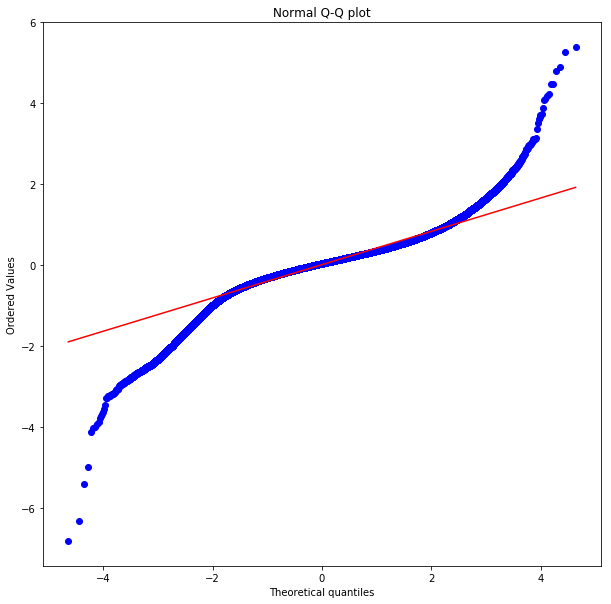

In [315]:
# Plotting Q-Q Plot
plt.figure(figsize=(10,10))
stats.probplot(res,dist='norm',plot=plt)
plt.title('Normal Q-Q plot')
plt.show();

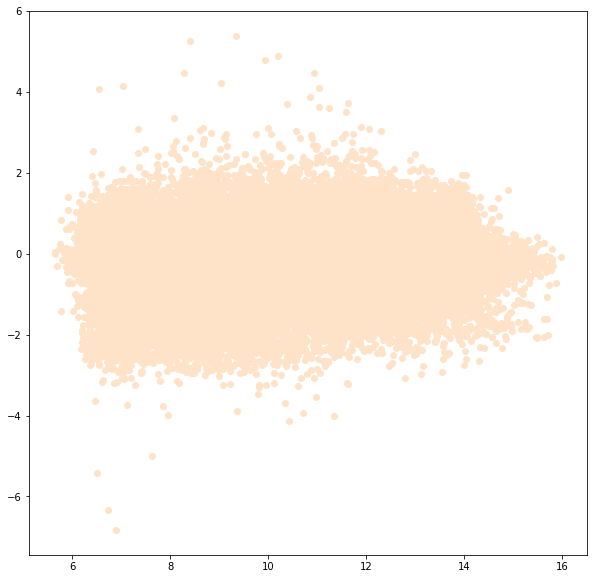

In [316]:
# Plotting predictions versus residuals
plt.figure(figsize=(10,10))
plt.scatter(final_y_prediction,res);

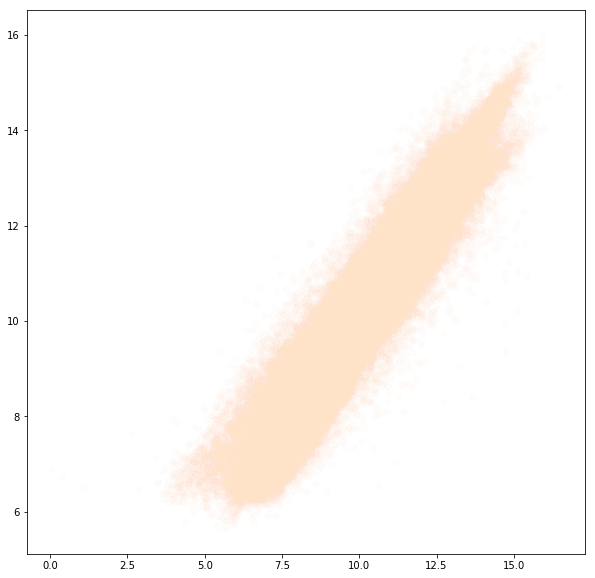

In [317]:
# Predicted vs actual
plt.figure(figsize=(10,10))
plt.scatter(y_test, final_y_prediction, alpha=.05);

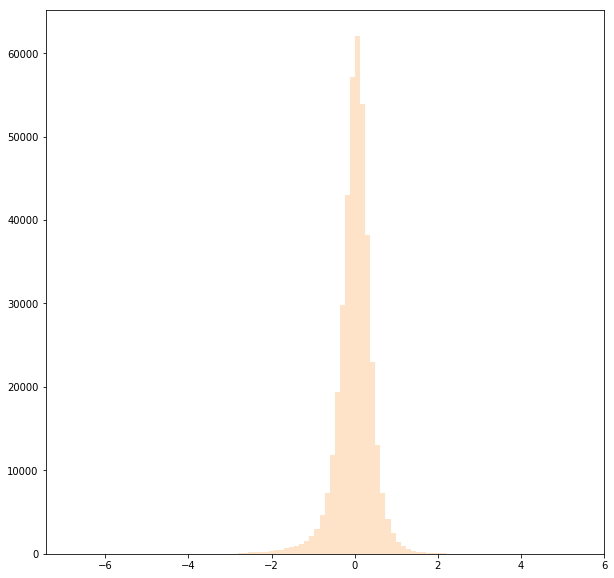

In [318]:
# Histogram of residuals
plt.figure(figsize=(10,10))
plt.hist(res, bins=100);

## Determining the Most Important Features of the Model

In [322]:
ridge_coeffs = [x for x in lm_reg.coef_[0]]

In [323]:
# Looking at how LASSO affected the coefficients
ridge_coeffs = list(zip(X.columns, ridge_coeffs))

In [324]:
ridge_coeffs

[('Intercept', 0.0),
 ('NPPES_PROVIDER_GENDER[T.M]', 0.017032208975713316),
 ('NPPES_PROVIDER_STATE[T.AL]', -0.04697171876315139),
 ('NPPES_PROVIDER_STATE[T.AR]', -0.03618347262214015),
 ('NPPES_PROVIDER_STATE[T.AZ]', -0.029437525637672695),
 ('NPPES_PROVIDER_STATE[T.CA]', -0.044180591841587784),
 ('NPPES_PROVIDER_STATE[T.CO]', -0.028766419647798355),
 ('NPPES_PROVIDER_STATE[T.CT]', -0.027764791024039434),
 ('NPPES_PROVIDER_STATE[T.DC]', -0.012348423270729427),
 ('NPPES_PROVIDER_STATE[T.DE]', -0.013128634126506049),
 ('NPPES_PROVIDER_STATE[T.FL]', -0.05235683911728119),
 ('NPPES_PROVIDER_STATE[T.GA]', -0.04679194653367211),
 ('NPPES_PROVIDER_STATE[T.HI]', -0.012940905003074904),
 ('NPPES_PROVIDER_STATE[T.IA]', -0.03484272671216964),
 ('NPPES_PROVIDER_STATE[T.ID]', -0.023007082085800136),
 ('NPPES_PROVIDER_STATE[T.IL]', -0.04782738285196022),
 ('NPPES_PROVIDER_STATE[T.IN]', -0.046483712572043714),
 ('NPPES_PROVIDER_STATE[T.KS]', -0.03200888352107603),
 ('NPPES_PROVIDER_STATE[T.KY]', -0.

In [325]:
ridge_coeffs_sort = sorted(ridge_coeffs, key=lambda x: x[1], reverse=True)

In [413]:
ridge_coeffs_sort

[('TOTAL_SERVICES', 1.042144745732351),
 ('TOTAL_UNIQUE_BENES', 0.3577731089118582),
 ('PROVIDER_TYPE[T.General Surgery]', 0.08566502591135527),
 ('BENEFICIARY_RACE_WHITE_COUNT', 0.0768045784515997),
 ('BENEFICIARY_CC_CHF_PERCENT', 0.07063713400381186),
 ('PROVIDER_TYPE[T.Neurosurgery]', 0.06969390063250214),
 ('PROVIDER_TYPE[T.Ophthalmology]', 0.06272719622959884),
 ('PROVIDER_TYPE[T.Plastic and Reconstructive Surgery]', 0.05822718499830978),
 ('PROVIDER_TYPE[T.Anesthesiology]', 0.05493789428088819),
 ('BENEFICIARY_CC_CKD_PERCENT', 0.05434824754210085),
 ('PROVIDER_TYPE[T.Thoracic Surgery]', 0.050583768065921776),
 ('BENEFICIARY_CC_DEPR_PERCENT', 0.047301717279499604),
 ('PROVIDER_TYPE[T.Cardiac Surgery]', 0.04684815544955419),
 ('PROVIDER_TYPE[T.Orthopedic Surgery]', 0.04677069812295176),
 ('PROVIDER_TYPE[T.Certified Registered Nurse Anesthetist (CRNA)]',
  0.04317917899329798),
 ('BENEFICIARY_CC_IHD_PERCENT', 0.04292884595410523),
 ('PROVIDER_TYPE[T.Psychologist, Clinical]', 0.04072

In [326]:
# Top 10 Most Important Factors
top_10_features = ridge_coeffs_sort[:10]
top_10_features = pd.DataFrame(top_10_features)

In [327]:
top_10_features

,0,1
0,TOTAL_SERVICES,1.042145
1,TOTAL_UNIQUE_BENES,0.357773
2,PROVIDER_TYPE[T.General Surgery],0.085665
3,BENEFICIARY_RACE_WHITE_COUNT,0.076805
4,BENEFICIARY_CC_CHF_PERCENT,0.070637
5,PROVIDER_TYPE[T.Neurosurgery],0.069694
6,PROVIDER_TYPE[T.Ophthalmology],0.062727
7,PROVIDER_TYPE[T.Plastic and Reconstructive Sur...,0.058227
8,PROVIDER_TYPE[T.Anesthesiology],0.054938
9,BENEFICIARY_CC_CKD_PERCENT,0.054348


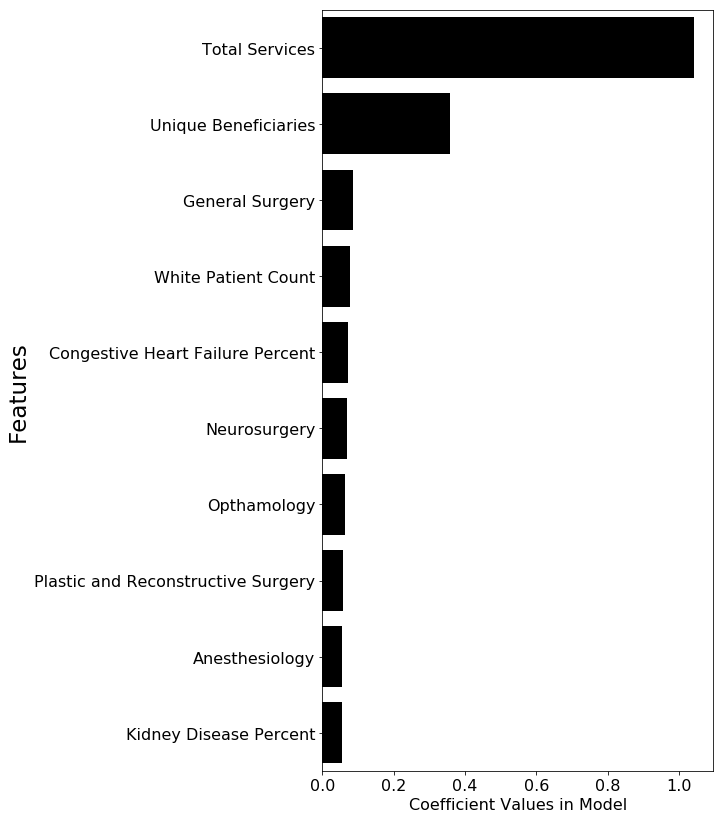

In [397]:
plt.figure(figsize=(7,14))
sns.barplot(y=top_10_features.iloc[:,0],x=top_10_features.iloc[:,1], orient="h", color="black")
plt.xlabel('Coefficient Values in Model', fontsize=16)
plt.yticks(ticks=range(10), labels=['Total Services','Unique Beneficiaries','General Surgery',
                                    'White Patient Count','Congestive Heart Failure Percent',
                                    'Neurosurgery','Opthamology','Plastic and Reconstructive Surgery',
                                    'Anesthesiology','Kidney Disease Percent'])
plt.ylabel('Features', fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=16);

In [380]:
# Most Important Specialties
top_specialties = []
for ix, row in enumerate(ridge_coeffs_sort):
    if 'PROV' in ridge_coeffs_sort[ix][0]:
        top_specialties.append(row)
print(top_specialties[:10])   

top_specialties = pd.DataFrame(top_specialties[:10])

[('PROVIDER_TYPE[T.General Surgery]', 0.08566502591135527), ('PROVIDER_TYPE[T.Neurosurgery]', 0.06969390063250214), ('PROVIDER_TYPE[T.Ophthalmology]', 0.06272719622959884), ('PROVIDER_TYPE[T.Plastic and Reconstructive Surgery]', 0.05822718499830978), ('PROVIDER_TYPE[T.Anesthesiology]', 0.05493789428088819), ('PROVIDER_TYPE[T.Thoracic Surgery]', 0.050583768065921776), ('PROVIDER_TYPE[T.Cardiac Surgery]', 0.04684815544955419), ('PROVIDER_TYPE[T.Orthopedic Surgery]', 0.04677069812295176), ('PROVIDER_TYPE[T.Certified Registered Nurse Anesthetist (CRNA)]', 0.04317917899329798), ('PROVIDER_TYPE[T.Psychologist, Clinical]', 0.04072211388952797)]


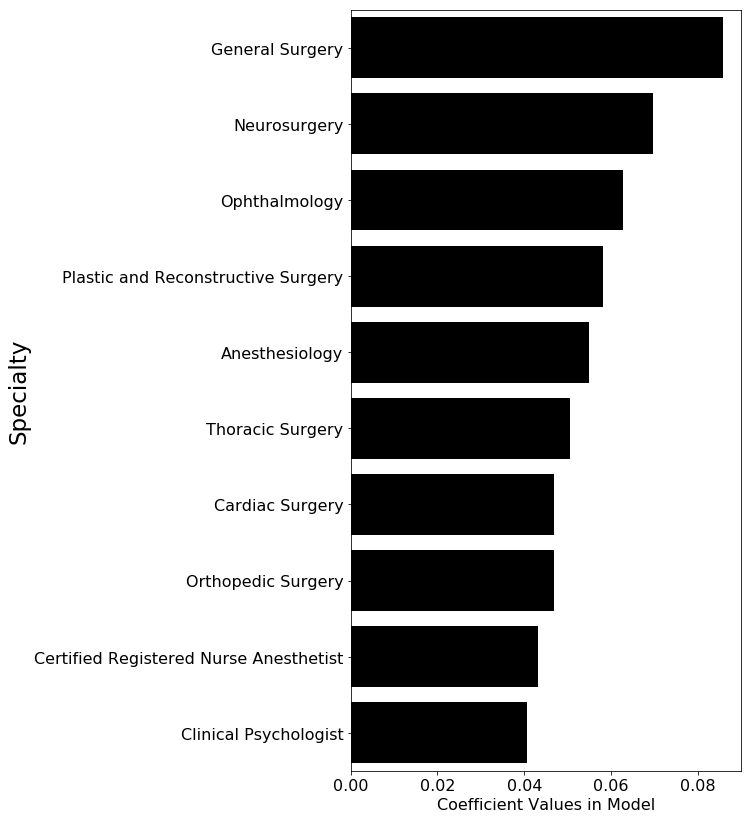

In [398]:
plt.figure(figsize=(7,14))
sns.barplot(y= top_specialties.iloc[:,0],x= top_specialties.iloc[:,1], orient="h", color="black")
plt.xlabel('Coefficient Values in Model', fontsize=16)
plt.yticks(ticks=range(10), labels=['General Surgery','Neurosurgery','Ophthalmology',
                   'Plastic and Reconstructive Surgery','Anesthesiology',
                   'Thoracic Surgery','Cardiac Surgery','Orthopedic Surgery',
                   'Certified Registered Nurse Anesthetist','Clinical Psychologist'])
plt.ylabel('Specialty', fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=16);

In [402]:
# Most Important Medical Conditions
top_med = []
for ix, row in enumerate(ridge_coeffs_sort):
    if 'PERC' in ridge_coeffs_sort[ix][0]:
        top_med.append(row)
print(top_med[:10])   

top_med = pd.DataFrame(top_med[:10])

[('BENEFICIARY_CC_CHF_PERCENT', 0.07063713400381186), ('BENEFICIARY_CC_CKD_PERCENT', 0.05434824754210085), ('BENEFICIARY_CC_DEPR_PERCENT', 0.047301717279499604), ('BENEFICIARY_CC_IHD_PERCENT', 0.04292884595410523), ('BENEFICIARY_CC_CANCER_PERCENT', 0.03646575428082754), ('BENEFICIARY_CC_ALZRDSD_PERCENT', 0.029269181632976548), ('BENEFICIARY_CC_RAOA_PERCENT', 0.026158842585418528), ('BENEFICIARY_CC_STRK_PERCENT', 0.02520205517345712), ('BENEFICIARY_CC_HYPERL_PERCENT', 0.0233465892412309), ('BENEFICIARY_CC_OST_PERCENT', 0.007766140262929086)]


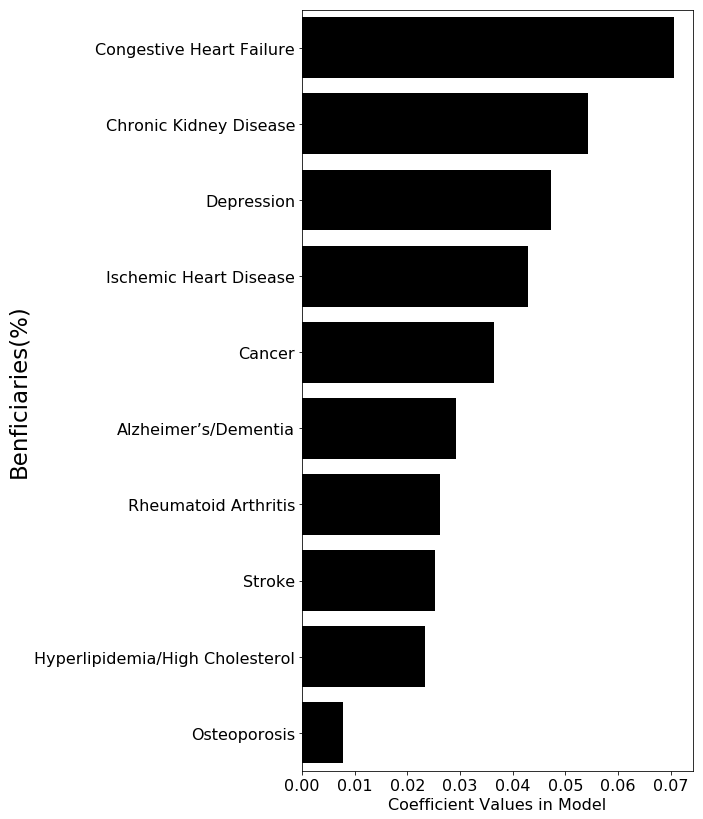

In [403]:
plt.figure(figsize=(7,14))
sns.barplot(y= top_med.iloc[:,0],x= top_med.iloc[:,1], orient="h", color="black")
plt.xlabel('Coefficient Values in Model', fontsize=16)
plt.yticks(ticks=range(10), labels=['Congestive Heart Failure','Chronic Kidney Disease','Depression',
                                    'Ischemic Heart Disease','Cancer','Alzheimer’s/Dementia',
                                    'Rheumatoid Arthritis','Stroke','Hyperlipidemia/High Cholesterol',
                                    'Osteoporosis'])
plt.ylabel('Benficiaries(%)', fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=16);

In [406]:
# Most Important States
# All states have negative coefficients
top_states = []
for ix, row in enumerate(ridge_coeffs_sort):
    if 'STATE' in ridge_coeffs_sort[ix][0]:
        top_states.append(row)
print(top_states[:10])   

# top_states = pd.DataFrame(top_states[:10])

[('NPPES_PROVIDER_STATE[T.WY]', -0.011833033923812178), ('NPPES_PROVIDER_STATE[T.DC]', -0.012348423270729427), ('NPPES_PROVIDER_STATE[T.HI]', -0.012940905003074904), ('NPPES_PROVIDER_STATE[T.DE]', -0.013128634126506049), ('NPPES_PROVIDER_STATE[T.NV]', -0.014036470480905783), ('NPPES_PROVIDER_STATE[T.MT]', -0.015068357999638047), ('NPPES_PROVIDER_STATE[T.VT]', -0.015607739308593058), ('NPPES_PROVIDER_STATE[T.NH]', -0.017736863894935055), ('NPPES_PROVIDER_STATE[T.RI]', -0.01853007070576061), ('NPPES_PROVIDER_STATE[T.MD]', -0.02077611986889909)]


In [411]:
# Bottom 10 States
# Could also possibly be interpreted as 
# the cheapest states for Medicare
top_states[40:]

[('NPPES_PROVIDER_STATE[T.KY]', -0.05093440694648384),
 ('NPPES_PROVIDER_STATE[T.WI]', -0.05162127215371517),
 ('NPPES_PROVIDER_STATE[T.MN]', -0.05228696605526345),
 ('NPPES_PROVIDER_STATE[T.FL]', -0.05235683911728119),
 ('NPPES_PROVIDER_STATE[T.TN]', -0.05404338130828936),
 ('NPPES_PROVIDER_STATE[T.NC]', -0.054362200209655466),
 ('NPPES_PROVIDER_STATE[T.MI]', -0.057752652543279596),
 ('NPPES_PROVIDER_STATE[T.PA]', -0.059998116852893676),
 ('NPPES_PROVIDER_STATE[T.OH]', -0.06490247859542715),
 ('NPPES_PROVIDER_STATE[T.TX]', -0.07125870213955972)]

In [468]:
# Race Coefficients
top_r = []
for ix, row in enumerate(ridge_coeffs_sort):
    if 'RACE' in ridge_coeffs_sort[ix][0]:
        top_r.append(row)
print(top_r[:10])   

top_r = pd.DataFrame(top_r[:10])

[('BENEFICIARY_RACE_WHITE_COUNT', 0.0768045784515997), ('BENEFICIARY_RACE_BLACK_COUNT', 0.01353817844120906), ('BENEFICIARY_RACE_API_COUNT', 0.013089362308637756), ('BENEFICIARY_RACE_HISPANIC_COUNT', 0.008985109425630076), ('BENEFICIARY_RACE_NATIND_COUNT', -0.0001810362195061302), ('BENEFICIARY_RACE_OTHER_COUNT', -0.0006016226498739636)]


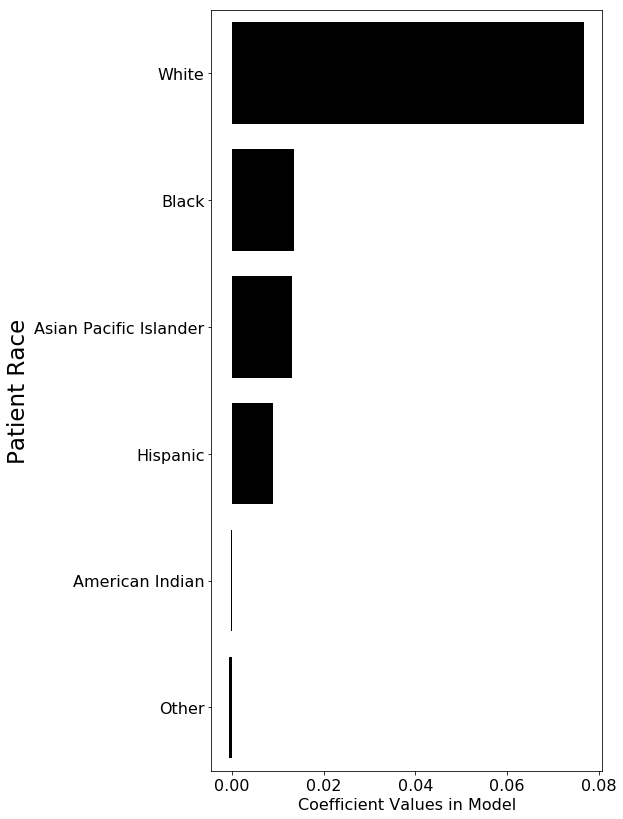

In [471]:
plt.figure(figsize=(7,14))
sns.barplot(y= top_r.iloc[:,0],x= top_r.iloc[:,1], orient="h", color="black")
plt.xlabel('Coefficient Values in Model', fontsize=16)
plt.yticks(ticks=range(6), labels=['White','Black','Asian Pacific Islander',
                                    'Hispanic','American Indian','Other'])
plt.ylabel('Patient Race', fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=16);